In [1]:
# python libraries
import os
import sys
from pathlib import Path
from operator import methodcaller
from collections import OrderedDict
import dataclasses
from dataclasses import dataclass
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Mapping
)
from enum import Enum
# adding the path
if not str(Path(os.getcwd()).parent) in sys.path:
    sys.path.append(str(Path(os.getcwd()).parent))

# numpy
import numpy as np

# torch
import torch
import torchvision
from torch import nn
from torchvision import (
    transforms,
    datasets
    )
from torch.utils.data import DataLoader

try:
    from torchmetrics import Accuracy
except:
    print(f"[INFO] Installing the torchmetrics")
    %pip install torchmetrics
    from torchmetrics import Accuracy

# helper function
try:
    import my_helper as helper
except:
    print("[INFO] Downloading the helper function from github")
    import requests
    response = requests.get("https://raw.githubusercontent.com/Lashi0812/PyTorch2/master/my_helper.py")
    with open("my_helper.py" ,"wb") as f:
        f.write(response.content)
    import my_helper as helper

[INFO] Installing the torchmetrics
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 6.7 MB/s eta 0:00:00
[INFO] Downloading the helper function from github


In [ ]:
## Connect Presistence memory
from google.colab import drive

# Paths
DRIVE_PATH = Path("/content/drive")
MODEL_SAVE_PATH = Path("/content/drive/Othercomputers/My PC/drive/models")

# mount drive
drive.mount(str(DRIVE_PATH))

# VGG Network

In [5]:
layer_arch = Tuple[int,int]

@dataclass(eq=False)
class VGG(helper.Classifier):
    arch:Tuple[layer_arch]
    lr:int = 0.01
    num_classes:int =10

    def  __post_init__(self):
        super().__init__()
        conv_blocks = []
        for num_convs,out_channels in self.arch:
            conv_blocks.append(self.vgg_block(num_convs,out_channels))
        self.net = nn.Sequential(
            *conv_blocks,nn.Flatten(),
            nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
            nn.LazyLinear(4096),nn.ReLU(),nn.Dropout(0.5),
            nn.LazyLinear(self.num_classes)
        )
        

    @staticmethod
    def vgg_block(num_convs,out_channels):
        layers = []
        for _ in range(num_convs):
            layers.append(nn.LazyConv2d(out_channels,kernel_size=3,padding=1))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
        return nn.Sequential(*layers)

    
    @staticmethod
    def init_vgg(module):
        if isinstance(module,(nn.Linear,nn.Conv2d)):
            nn.init.kaiming_normal_(module.weight)


In [3]:
arch = ((1,64),(1,128),(2,256),(2,512),(2,512))
VGG(arch).layer_summary((1,1,224,224))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential      output shape :(1, 64, 112, 112)
Sequential      output shape :(1, 128, 56, 56)
Sequential      output shape :(1, 256, 28, 28)
Sequential      output shape :(1, 512, 14, 14)
Sequential      output shape :(1, 512, 7, 7)
Flatten         output shape :(1, 25088)
Linear          output shape :(1, 4096)
ReLU            output shape :(1, 4096)
Dropout         output shape :(1, 4096)
Linear          output shape :(1, 4096)
ReLU            output shape :(1, 4096)
Dropout         output shape :(1, 4096)
Linear          output shape :(1, 10)


Training the model in cuda


  0%|          | 0/10 [00:00<?, ?it/s]

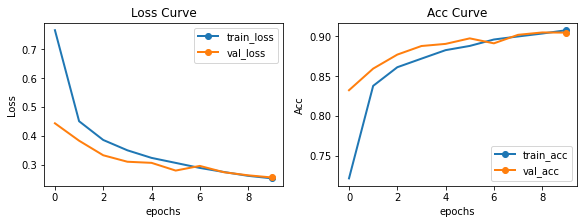

In [7]:
# Training process is not same as original paper

#? they start 1st conv block with 64 here we start with 16
arch = ((1,16),(1,32),(2,64),(2,128),(2,128))

#? we use the same learning rate as in the original paper , 
#? we didn't use the momentum and weight decay
model = VGG(arch,lr=0.01)

#? data we use is Fashion mnist
#? batch we reduce 128 original paper use the 256
#? there is not transform such horizontal flip
#? we didn't use the different scale for training image.
data = helper.FashionMNIST(batch_size=128,resize=(224,224))

#? training done with 10 epoch original they trained for 74 epoch
trainer = helper.Trainer(max_epochs=10)

#? Initialization is totally different 
#? original paper use the different initialization for mostly pertained from the shallow model
model.apply_init([next(iter(data.train_dataloader()))[0]],model.init_vgg)

trainer.fit(model,data)

In [11]:
# save the models
MODEL_NAME = "vgg-1.pth"
torch.save(model.state_dict(),MODEL_SAVE_PATH/MODEL_NAME)